Tenemos un dataset con datos históricos de varias variables promediadas en valores diarios de 6 los últimos 6 años.

Se tiene el siguiente diccionario de datos:
- La columna de índice es la fecha.
- PresionAire: es la presión del aire en milibars
- PresionVapor: es la presión del vapor de agua en el aire en milibars
- Humedadrelativa: es el porcentaje de humedad relativa
- ConcentracionVapor: es la concentración del vapor de agua en mmol/mol
- DensidadAire: es la densidad del aire en g/metros cúbicos
- DireccionViento: es la dirección del viento en grados
- Temperatura: es la temperatura en grados centigrados

In [78]:
import IPython
import IPython.display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import seaborn as sns
import math as mt

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso #modelamiento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
import sklearn as sk
print(sk.__version__)

0.23.2


In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [5]:
# Imprima 4 filas del inicio y 4 al final
pd.set_option('display.max_rows', 20)

In [6]:
df = pd.read_csv("datos_clima.csv")

In [7]:
# Se verifica la carga
df

,Unnamed: 0,PresionAire (mbar),PresionVapor (mbar),HumedadRelativa (%),ConcentracionVapor (mmol/mol),DensidadAire (g/m**3),DireccionViento (grado),Temperatura (C)
0,01.01.2010,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403
1,02.01.2010,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667
2,03.01.2010,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903
3,04.01.2010,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306
4,05.01.2010,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736
...,...,...,...,...,...,...,...,...
2188,27.12.2015,1002.411250,8.530347,79.140625,8.510764,1237.405625,190.177083,8.167083
2189,28.12.2015,1002.468194,7.347917,91.898611,7.329375,1257.736389,153.824792,3.761111
2190,29.12.2015,1003.816736,7.504514,94.815278,7.478403,1260.613194,187.764653,3.485625
2191,30.12.2015,998.772639,4.638125,67.657431,4.641250,1265.083611,178.779861,1.395694


In [8]:
# se verifican los tipos
df.dtypes

Unnamed: 0                        object
PresionAire (mbar)               float64
PresionVapor (mbar)              float64
HumedadRelativa (%)              float64
ConcentracionVapor (mmol/mol)    float64
DensidadAire (g/m**3)            float64
DireccionViento (grado)          float64
Temperatura (C)                  float64
dtype: object

<h1>Preparación general de los datos

- Renombramiento de columnas
- Conversión de columnas tipos fechas
- Ordenamiento por fechas
- Redondeo de los valores
- Revisión de la calidad de los datos

In [9]:
df.columns = ['Fecha', 'P.Aire', 'P.Vapor', 'Hum.Rel', 'C.Vapor', 'D.Aire', 'D.Vapor', 'Temp']

In [10]:
# se cambia el tipo de la columna 0 a Date
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y');
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Fecha    2193 non-null   datetime64[ns]
 1   P.Aire   2193 non-null   float64       
 2   P.Vapor  2193 non-null   float64       
 3   Hum.Rel  2193 non-null   float64       
 4   C.Vapor  2193 non-null   float64       
 5   D.Aire   2193 non-null   float64       
 6   D.Vapor  2193 non-null   float64       
 7   Temp     2193 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 137.2 KB


In [11]:
# Ordenamiento del dataframe
df.sort_values(by=['Fecha'])

,Fecha,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp
0,2010-01-01,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403
1,2010-01-02,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667
2,2010-01-03,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903
3,2010-01-04,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306
4,2010-01-05,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736
...,...,...,...,...,...,...,...,...
2188,2015-12-27,1002.411250,8.530347,79.140625,8.510764,1237.405625,190.177083,8.167083
2189,2015-12-28,1002.468194,7.347917,91.898611,7.329375,1257.736389,153.824792,3.761111
2190,2015-12-29,1003.816736,7.504514,94.815278,7.478403,1260.613194,187.764653,3.485625
2191,2015-12-30,998.772639,4.638125,67.657431,4.641250,1265.083611,178.779861,1.395694


In [12]:
# test = pd.concat([df, 'Temp2'=df.iloc[1:,len(df.columns)-1:]])
# test.head()
target = df.iloc[3:,len(df.columns)-1:]
# target.reset_index(drop=True, inplace=True)
target.head()

prueba = df.copy()
prueba['Temp2'] = target
prueba.head()

,Fecha,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp,Temp2
0,2010-01-01,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403,NaN
1,2010-01-02,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667,NaN
2,2010-01-03,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903,NaN
3,2010-01-04,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306,-6.284306
4,2010-01-05,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736,-10.286736


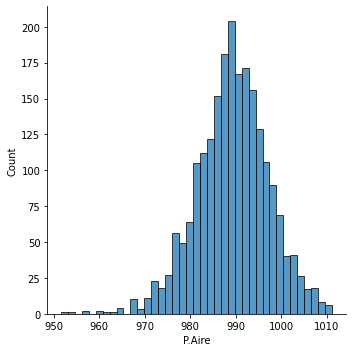

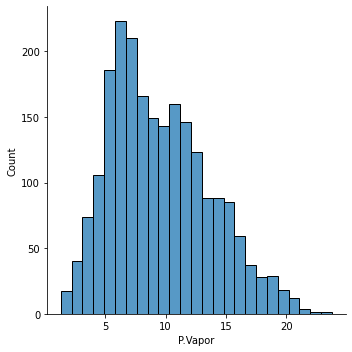

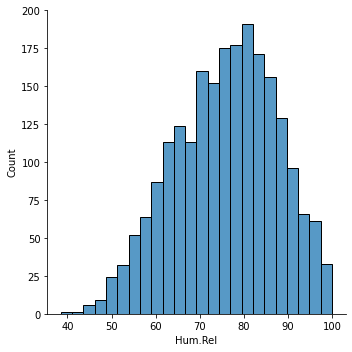

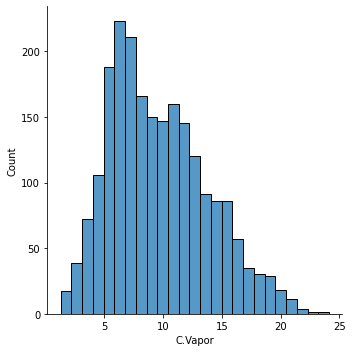

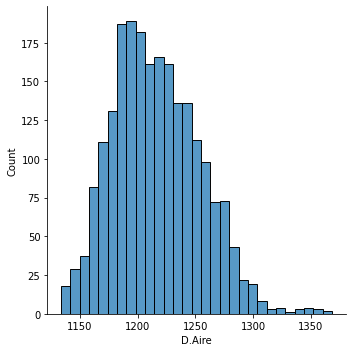

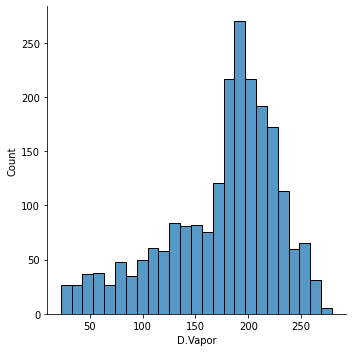

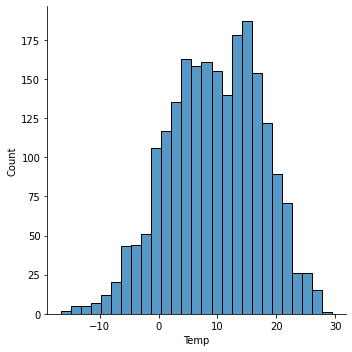

In [13]:
import matplotlib.pyplot as plt
for col in df.columns[1:]:
    df[col] = df[col].round(decimals=2) # Redondeo de los valores a 0 decimales
    # df[col] = df[col].astype(int)       # Las predicciones no reciben float
    sns.displot(df, x=col)

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
P.Aire,2193.0,989.291952,7.913174,951.56,984.38,989.46,994.39,1011.20
P.Vapor,2193.0,9.528664,4.106531,1.30,6.28,8.91,12.23,23.80
Hum.Rel,2193.0,75.839558,11.592708,38.50,67.52,76.75,84.44,100.00
C.Vapor,2193.0,9.635121,4.157923,1.29,6.34,8.98,12.36,24.12
D.Aire,2193.0,1216.120219,37.622388,1133.43,1188.26,1212.65,1242.08,1368.36
D.Vapor,2193.0,174.249950,54.484004,22.57,141.96,187.76,211.46,279.37
Temp,2193.0,9.462321,7.861140,-16.58,3.90,9.72,15.36,29.45


Se busca ahora comenzar a generar el corte transversal, haciendo variables promedio: 

# Parte 1: Modelos shallow (3 puntos)

Utilizando modelos shallow (por oposición a profundos), desarrolle modelos predictivos que permitan predecir la temperatura del séptimo día siguiente:

- No utilice modelos de forecasting como ARIMA o Holt-Winters
- Establezca variables a partir de los datos históricos. Por ejemplo, puede establecer datos como la temperatura promedio de los últimos 3 días, de los últimos 7 días, de los últimos 10 días, la presión del aire mínima de los últimos 3 días, de los últimos 7 días, de los últimos 15 días, los valores del día anterior de todas las variables, lo valores de hace 1 año en la misma fecha, etc.
- Debe crear un dataset de corte transversal, estimando las variables a utilizar cada día, o cada semana, o cada mes.
- Utilice modelos como SVM y redes neuronales artificiales tradicionales
- Utilice técnicas de seleccion de variables como PCA, LDA y Lasso
- Intente aplicar diferentes técnicas de normalización

<h1>1.1 Creación de los data sets

## 1.1.1 Creación del data frame de corte transversal

Para la creación del Dataframe de corte transversal se tendran en cuenta periodos de 7 y 15 días, se realizará tambien una asignación basada en medidas estadísticas básicas, máximo, mínimo y promedio.

- Definición de la ventada (7 días anteriores)
- Creación de las variables con base a la ventana para poder usarlo como una base de corte transversal:
    - Prom: Promedio de los últimos valores de la ventana
    - Max: Máximo de los últimos valores de la ventana
    - Min: Mínimo de los últimos valores de la ventana    

In [ ]:
# Creamos un nuevo data frame para no modificar el original
df1 = pd.DataFrame()

# ventana = 3
# Generamos las variables de corte transversal
for ventana in [7,15,30]:
    for col in df.columns[1:]:
        prom = df[col].rolling(window=ventana).mean()
        nom_col = col + '.Prom.' + str(ventana) + ' días'
        df1[nom_col] = prom
        max  = df[col].rolling(window=ventana).max()
        nom_col = col + '.Max.' + str(ventana) + ' días'
        df1[nom_col] = max
        min  = df[col].rolling(window=ventana).min()
        nom_col = col + '.Min.' + str(ventana) + ' días'
        df1[nom_col] = min 

# Agregamos la variable dependiente (Temperatura del septimo día)
target = df.iloc[6:,len(df.columns)-1:]
target.reset_index(drop=True, inplace=True)
df1['Temp.Target.7'] = target
# df1 = pd.concat([df1, df['Temp']], axis=1)

df1.info() 

<h2>1.1.2 Limpieza de datos

In [ ]:
df1.head()

Se realiza el proceso de limpieza a través de la eliminación de registros no válidos.

- Eliminar los registros con variables nulas generados por los primeros N registros menores a la ventana 

In [ ]:
df1.dropna(inplace=True)
df1.info()

In [ ]:
df1.reset_index(drop=True, inplace=True)
df1.head()

<h2>1.1.3 Particionamiento de los datos

- Reordenar aleatoriamente los registros del data frame de corte transversal
- Particionar el data frame en 70% entrenamiento y 30% test

In [ ]:
# Semilla para poder replicar el ejercicio
random_state = 40

In [ ]:
#df1.reset_index(drop=True, inplace=True)

In [ ]:
# Proceso Manual
# X_train = df1.iloc[:1530,:]
# X_train = X_train.sample(frac=1, random_state=random_state)
# y_train = X_train['Temp'] 
# X_train = X_train.iloc[:,:len(X_train.columns)-1]
# X_test = df1.iloc[:1530,:]
# y_test = X_test['Temp'] 
# X_test = X_test.iloc[:,:len(X_test.columns)-1]

# Proceso automatizado
X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,:len(df1.columns)-1], df1['Temp.Target.7'], train_size=0.7, shuffle=False)

In [ ]:
# Verificamos el contenido del set de entrenamiento (independientes)
X_train.head()

In [ ]:
# Verificamos el contenido del set de entrenamiento (dependiente)
y_train.head()

In [ ]:
# Modifica el orden de los datos de prueba pero conservando la relación entre las variable X y la Y
X_train = X_train.sample(frac=1, random_state=random_state)
y_train = y_train.sample(frac=1, random_state=random_state)

In [ ]:
print(X_train.iloc[:,:1].head(),'\n')
print(type(y_train))
print(type(X_train))


<h2> 1.2 Pipelines de entrenamiento y evaluación del mejor modelo

Para seleccionar el mejor modelo se compararán los algoritmos de PCA, LDA y Lasso con base a la métrica <u>r2</u>

Utilizando objetos **Pipeline**, encuentren el mejor modelo **SVC** para el dataset analizado. Haga diferentes intentos, variando:

- el tipo de normalización utilizada (Sin normalización, con **StandardScaler**)
- el tipo de reducción de dimensionalidad (Sin reducción, con **PCA**, con **LDA**), especificando None, 10, 15 y 20 dimensiones
- el tipo de kernel utilizado por un modelo **SVC** (linear, rbf, o sigmoid). El kernel poly, al tener 26 variables no es una opción viable.
- el valor del parámetro *C*
- el valor del parámetro *gamma* cuando aplique

Trabaje sobre el 70% de los datos, particionados de manera estratificada según la variable objetivo.

Utilice 'r2', como medida de evaluación de la calidad del ajuste de los modelos, usando el protocolo de evaluación de cross-validation con 5 folds.

Compare las curvas ROC AUC de los 2 mejores clasificadores encontrados.

In [ ]:
metrica = "r2"

<h2>1.2.1 Modelos

(A) Modelo con el siguiente pipeline:

- Sin Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel linear

Se monta sobre un grid de búsqueda con parámetros para SVR(linear).

In [ ]:
steps = [("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}

grid2 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid2.fit(X_train,y_train)  
print("score = %3.4f" %(grid2.score(X_test,y_test)))
print(grid2.best_params_)

train_score2 = grid2.score(X_train, y_train)
test_score2 = grid2.score(X_test, y_test)
print ( "train: ", train_score2 , "test", test_score2)

(B) Modelo con el siguiente pipeline:

- Sin Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel rbf

Se monta sobre un grid de búsqueda con parámetros para SVR(rbf).

In [ ]:
steps = [("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}

grid3 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid3.fit(X_train,y_train)  
print("score = %3.4f" %(grid3.score(X_test,y_test)))
print(grid3.best_params_)

train_score3 = grid3.score(X_train, y_train)
test_score3 = grid3.score(X_test, y_test)
print ( "train: ", train_score3 , "test", test_score3)

(C) Modelo con el siguiente pipeline:

- Sin Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel sigmoid
- Se monta sobre un grid de búsqueda con parámetros para SVR(sigmoid) / C + Gamma.

In [ ]:
steps = [("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}

grid4 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid4.fit(X_train,y_train)  
print("score = %3.4f" %(grid4.score(X_test,y_test)))
print(grid4.best_params_)

train_score4 = grid4.score(X_train, y_train)
test_score4 = grid4.score(X_test, y_test)
print ( "train: ", train_score4 , "test", test_score4)

De los modelos probados, el mejor resultado está en el pipeline del modelo (B) (Sin Estandarización, Máquina de vector de soporte para regresión (SVR) con kernel linear). Los valores obtenbidos durante la evaluación fueron:

train:  0.7369 / test 0.5617

# Modelos con estandarización de los datos:

(A1) Modelo con el siguiente pipeline:

- Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel linear

Se monta sobre un grid de búsqueda con parámetros para SVR(linear).

In [ ]:
steps = [('STD', StandardScaler()), ("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10]}

grid5 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid5.fit(X_train, y_train)
print("score = %3.4f" %(grid5.score(X_test,y_test)))
print(grid5.best_params_)

train_score5 = grid5.score(X_train, y_train)
test_score5 = grid5.score(X_test, y_test)
print ( "train: ", train_score5 , "test", test_score5)

(A2) Modelo con el siguiente pipeline:

- Estandarización
- Máquina de vector de soporte para regresión (SVR) con kernel rbf

Se monta sobre un grid de búsqueda con parámetros para el SVR(rbf) - C / Gamma

In [ ]:
steps = [('STD', StandardScaler()),("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10], 'SVM_rbf__gamma':[0.05,0.01, 1, 5]}

grid6 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid6.fit(X_train, y_train)
print("score = %3.4f" %(grid6.score(X_test,y_test)))
print(grid6.best_params_)

train_score6 = grid6.score(X_train, y_train)
test_score6 = grid6.score(X_test, y_test)
print ( "train: ", train_score6 , "test", test_score6)

(A3) Modelo con el siguiente pipeline:

-Estandarización

-Máquina de vector de soporte para regresión (SVR) con kernel sigmoide

-Se monta sobre un grid de búsqueda con parámetros para el SVR(rbf) - C / Gamma

In [ ]:
steps = [('STD', StandardScaler()), ("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5]}

grid7 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid7.fit(X_train, y_train)
print("score = %3.4f" %(grid7.score(X_test,y_test)))
print(grid7.best_params_)

train_score7 = grid7.score(X_train, y_train)
test_score7 = grid7.score(X_test, y_test)
print ( "train: ", train_score7 , "test", test_score7)
#Overfitting (yet)

Los modelos evaluados con estandarización, mostraron ser más robustos que aquellos sin estandarización, con resultados más consistentes. El mejor modelo de esta etapa fue el (A3) con pipeline (Estandarización, 
Máquina de vector de soporte para regresión (SVR) con kernel sigmoide, Se monta sobre un grid de búsqueda con parámetros para el SVR(rbf) - C / Gamma).

Se destaca que los valores obtenidos, muestran una mejor diferencia entre los conjuntos de entrenamiento y prueba,dando indicios de no overfitting

train:  0.6779 / test 0.6383

## Modelos con estandarización de los datos y PCA:

(B1) Modelo con el siguiente pipeline:

- Estandarización
- Analisis de componentes principales (PCA)
- Máquina de vector de soporte para regresión (SVR) con kernel rbf

Se monta sobre un grid de búsqueda con parámetros para PCA y el SVR(rbf) solo con C

In [ ]:
steps = [('STD', StandardScaler()),
         ('PCA', PCA()),
         ("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)         
parametros = {'PCA__n_components':[None, 10, 15, 20], 'SVM_rbf__C':[0.01,0.1,1,10]}  

grid0 = GridSearchCV(pipeline, parametros, cv=5, scoring=metrica) 
grid0.fit(X_train,y_train)     
print("score = %3.4f" %(grid0.score(X_test,y_test)))
print(grid0.best_params_)

train_score0 = grid0.score(X_train, y_train)
test_score0 = grid0.score(X_test, y_test)
print ( "train: ", train_score0 , "test", test_score0)
# Los valores obtenidos muestran incidencia de Overfitting en el modelo con una diferencia elevada entre el test y el train.

(B2) Modelo con el siguiente pipeline:

- Estandarización
- Analisis de componentes principales (PCA)
- Máquina de vector de soporte para regresión (SVR) con kernel linear

Se monta sobre un grid de búsqueda con parámetros para PCA y el SVR(linear).

In [ ]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_linear", SVR(kernel="linear"))]
pipeline = Pipeline(steps)
parametros = {'SVM_linear__C':[0.01,0.1,1,10], 'PCA__n_components':[None, 5, 10, 15, 20]}

grid8 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid8.fit(X_train, y_train)
print("score = %3.4f" %(grid8.score(X_test,y_test)))
print(grid8.best_params_)

train_score8 = grid8.score(X_train, y_train)
test_score8 = grid8.score(X_test, y_test)
print ( "train: ", train_score8 , "test", test_score8)

(B3) Modelo con el siguiente pipeline:

- Estandarización
- Analisis de componentes principales (PCA)
- Máquina de vector de soporte para regresión (SVR) con kernel rbf

Se monta sobre un grid de búsqueda con parámetros para PCA y el SVR(linear), con C y Gamma

In [ ]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_rbf", SVR(kernel="rbf"))]
pipeline = Pipeline(steps)
parametros = {'SVM_rbf__C':[0.01,0.1,1,10, 20], 'SVM_rbf__gamma':[0.05,0.01, 1, 5, 10], 'PCA__n_components':[None, 10, 15, 20]}

grid9 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid9.fit(X_train, y_train)
print("score = %3.4f" %(grid9.score(X_test,y_test)))
print(grid9.best_params_)

train_score9 = grid9.score(X_train, y_train)
test_score9 = grid9.score(X_test, y_test)
print ( "train: ", train_score9 , "test", test_score9)

(B4) Modelo con el siguiente pipeline:

- Estandarización
- Analisis de componentes principales (PCA)
- Máquina de vector de soporte para regresión (SVR) con kernel sigmoide

Se monta sobre un grid de búsqueda con parámetros para PCA y el SVR(linear), con C y Gamma

In [ ]:
steps = [('STD', StandardScaler()), ('PCA', PCA()), ("SVM_sigmoid", SVR(kernel="sigmoid"))]
pipeline = Pipeline(steps)
parametros = {'SVM_sigmoid__C':[0.01,0.1,1,10], 'SVM_sigmoid__gamma':[0.05,0.01, 1, 5], 'PCA__n_components':[None, 10, 15, 20]}

grid10 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica)
grid10.fit(X_train, y_train)
print("score = %3.4f" %(grid10.score(X_test,y_test)))
print(grid10.best_params_)

train_score10 = grid10.score(X_train, y_train)
test_score10 = grid10.score(X_test, y_test)
print ( "train: ", train_score10 , "test", test_score10)

Tras evaluar diferentes modelos asociados a la utilización de PCA más estadarización, se obtiene que el mejor modelo continúa siendo el (A3) de la sección previa, con un resultado de comparación de:

train:  0.6779 / test 0.6383

En la presente sección, los modelos (B) mostraron altos grados en Overfitting.

In [ ]:
# Resultados con SVR tras difentes procesos de reducción de dimensionalidad y estandarización.

print ( "Grid0 "+"\t train: ", train_score0 , "\t test", test_score0)
# print ( "Grid1 "+"\t train: ", train_score1 , "\t test", test_score1)
print ( "Grid2 "+"\t train: ", train_score2 , "\t test", test_score2)
print ( "Grid3 "+"\t train: ", train_score3 , "\t test", test_score3)
print ( "Grid4 "+"\t train: ", train_score4 , "\t test", test_score4)
print ( "Grid5 "+"\t train: ", train_score5 , "\t test", test_score5)
print ( "Grid6 "+"\t train: ", train_score6 , "\t test", test_score6)
print ( "Grid7 "+"\t train: ", train_score7 , "\t test", test_score7)
print ( "Grid8 "+"\t train: ", train_score8 , "\t test", test_score8)
print ( "Grid9 "+"\t train: ", train_score9 , "\t test", test_score9)
print ( "Grid10 "+"\t train: ", train_score10 , "\t test", test_score10)

# Utilización de regresiones controladas con Ridge y Lasso

In [ ]:
# Vamos a trabajar con Ridge y Lasso

# Calculamos la matriz de correlaciones
corr = X_train.join(y_train).corr()
corr


In [ ]:
# Mecanismo para graficar obtenido de los talleres de la clase.

f, ax = plt.subplots(figsize=(20, 20))
# Mapa de colores
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Borramos la parte diagonal superior con una máscara
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0, mask=mask, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Como el DataSet fue construido a través de la construccion de caracteristicas usando máximos, minimos y promedios se pueden observar bloques de correlación.

"scikit-learn no ofrece el cálculo del R2 ajustado (viva Python!), por lo que lo calculamos a mano" (Diaz, Javier, 2020)

In [ ]:
def r2adj(y_real, y_pred, numFeatures):
    return 1 - (1-r2_score(y_real, y_pred))*(len(y_real)-1) / (len(y_real) - numFeatures - 1)

In [ ]:
regr = LinearRegression( normalize=True )
regr.fit(X_train, y_train)

In [ ]:
# indep_vars = df1.columns # en el taller se usa el dataframe completo, ¿eso no está mal?
indep_vars = X_train.columns # 

for var, coef in zip(indep_vars, np.squeeze(regr.coef_)):
    print("{}: {}".format(var, coef))
print("intercepción: {}".format(np.squeeze(regr.intercept_)))

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso #modelamiento
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import KFold, cross_val_score #protocolo de evaluación
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score #métricas de evaluación
from sklearn.preprocessing import scale 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

train_y_pred = regr.predict(X_train)
test_y_pred = regr.predict(X_test)
print(train_y_pred.shape)
print(test_y_pred.shape)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))


Regresión linear normalizada, línea base con todas las variables independientes.

Métricas 

MSE (train): 14.9404

MSE (test) : 24.4578

R2  (train): 0.7636

R2  (test) : 0.4720

R2 adj (train): 0.7533

R2 adj (test): 0.4151

In [ ]:
train_x2 = sm.add_constant(X_train.values)
modeloStats = sm.OLS(np.asarray(y_train), train_x2)
results = modeloStats.fit()
#Consultamos la calidad del modelo a partir de sus estadísticas
results.summary()

El análisis estadístico muestra fuerte multicolinealidad, lo cual era predecible por la forma de construcción de del DataSet.

### Para el siguiente tramo, se realiza una revisión de la correlación con la variables objetivo: "Temp.Target.7"

In [ ]:
correlacionesSalario = corr['Temp.Target.7']
print(correlacionesSalario)

Se observan las variables de mayor correlación, se seleccionan: 

- Temperatura promedio 30 días y la Densidad de aire 7 días.

In [ ]:
train_x_red = X_train[['Temp.Prom.30 días', 'D.Aire.Max.7 días']]
test_x_red = X_test[['Temp.Prom.30 días', 'D.Aire.Max.7 días']]
regr_red = LinearRegression(normalize=True)
regr_red.fit(train_x_red, y_train)

In [ ]:
train_y_pred = regr_red.predict(train_x_red)
test_y_pred = regr_red.predict(test_x_red)
print(train_y_pred.shape)
print(test_y_pred.shape)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

Regresión linear normalizada, línea base con todas las variables independientes.

Métricas
 
(PREVIO)
R2 adj (train): 0.7533
R2 adj (test): 0.4151

----------------------------
(ACTUAL)
R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

In [ ]:
train_x2 = sm.add_constant(train_x_red.values)
modeloStats = sm.OLS(np.asarray(y_train), train_x2)
results = modeloStats.fit()
results.summary()

El análisis estadístico muestra fuerte multicolinealidad, lo cual era predecible por la forma de construcción de del DataSet.

## Modelos usando: Ridge regression

Se realiza el cálculo de alphas en espacio logarítmico.

In [ ]:
metrica = 'r2' #'neg_mean_squared_error'
n_alphas = 200
alphas = np.logspace(-6, 2, n_alphas)
alphas[:5]

(C1) Modelo con el siguiente pipeline:

- Estandarización
- Regresión de Ridge (L2) ajustado al intercepto sin normalización.

Se monta sobre un grid de búsqueda con parámetros para Ridge usando los alphas previamente claculados.

In [ ]:
steps = [('STD', StandardScaler()), ("RidgeReg", Ridge(fit_intercept=True, normalize=False))]
pipeline = Pipeline(steps)
parametros = {'RidgeReg__alpha':alphas}

grid1A = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
grid1A.fit(X_train, y_train)
print(grid1A.best_params_)

train_y_pred = grid1A.best_estimator_.predict(X_train)
test_y_pred = grid1A.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = grid1A.score(X_train, y_train)
test_score_p = grid1A.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)



(PREVIO)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL)

R2 adj (train): 0.7486
R2 adj (test): 0.4456

(C2) Modelo con el siguiente pipeline:

- Sin Estandarización
- Regresión de Ridge (L2) ajustado al intercepto sin normalización.

Se monta sobre un grid de búsqueda con parámetros para Ridge usando los alphas previamente claculados.

In [ ]:
steps = [("RidgeReg", Ridge(fit_intercept=True, normalize=False))]
pipeline = Pipeline(steps)
parametros = {'RidgeReg__alpha':alphas}
grid2B = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
grid2B.fit(X_train, y_train)
print(grid2B.best_params_)

train_y_pred = grid2B.best_estimator_.predict(X_train)
test_y_pred = grid2B.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = grid2B.score(X_train, y_train)
test_score_p = grid2B.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

(PREVIO MEJOR)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL)

R2 adj (train): 0.7524 R2 adj (test): 0.4303

(C3) Modelo con el siguiente pipeline:

- Estandarización
- Regresión de Ridge (L2) ajustado al intercepto con normalización.

Se monta sobre un grid de búsqueda con parámetros para Ridge usando los alphas previamente calculados.

In [ ]:
steps = [('STD', StandardScaler()),("RidgeReg", Ridge(fit_intercept=True, normalize=True))]
pipeline = Pipeline(steps)
parametros = {'RidgeReg__alpha':alphas}

grid2C = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
grid2C.fit(X_train, y_train)
print(grid2C.best_params_)

train_y_pred = grid2C.best_estimator_.predict(X_train)
test_y_pred = grid2C.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = grid2C.score(X_train, y_train)
test_score_p = grid2C.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

(PREVIO MEJOR)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL)

R2 adj (train): 0.7319
R2 adj (test): 0.5191

Tras realizar 3 modelos basados en Ridge, se encontró que el mejor resultado basado en la métrica R2-adj, es el módelo (C1) con estandarización y Ridge no normalizado.

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor) 

In [ ]:
stdmodel = StandardScaler()
train_x_std = stdmodel.fit_transform(X_train, np.ravel(y_train))
test_x_std = stdmodel.transform(X_test)

In [ ]:
coefs = []
r2adj_train_vec = []
r2adj_test_vec = []

for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True, normalize=True)
    ridge.fit(train_x_std, y_train)
    coefs.append(ridge.coef_)
    train_y_pred = ridge.predict(train_x_std)
    test_y_pred = ridge.predict(test_x_std)
    r2_aj_train = r2adj(y_train, train_y_pred, train_x_std.shape[1])
    r2_aj_test = r2adj(y_test, test_y_pred, test_x_std.shape[1])
    r2adj_train_vec.append(r2_aj_train)
    r2adj_test_vec.append(r2_aj_test)

In [ ]:
plt.figure(figsize=(12,4))
ax = plt.gca() # get current axis
plt.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefs')
plt.title('Coeficientes de Ridge en función del parámetro de regularización')
plt.legend(indep_vars, loc="right")

In [ ]:
# buscamos las variables más importantes

t1 = np.array(r2adj_train_vec)
t1 = t1[:, np.newaxis]
print("train: ", t1.shape)

t2 = np.array(r2adj_test_vec)
t2 = t2[:, np.newaxis]
print("test: ", t2.shape)

r2adj_vecs = np.concatenate((t1, t2), axis=1)
print("concatenación: ", r2adj_vecs.shape)

In [ ]:
plt.figure(figsize=(18,9))
ax = plt.gca()
plt.plot(alphas, r2adj_vecs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('R2 ajustado')
plt.title('R2 ajustado con respecto al alpha')
plt.legend(['train', 'test'])

## Modelos usando: Lasso regression

In [ ]:
# Se generan los Alphas 
n_alphas = 200
alphas = np.logspace(-2, 2, n_alphas)
alphas[:5]

(D1) Modelo con el siguiente pipeline:

- Estandarización
- Regresión de Lasso (L1) ajustado al intercepto sin normalización.

Se monta sobre un grid de búsqueda con parámetros para Lasso usando los alphas previamente calculados.

In [ ]:
steps = [('STD', StandardScaler()), ("LassoReg", Lasso(fit_intercept=True, normalize=False, max_iter=10000, tol=0.01))]
pipeline = Pipeline(steps)
parametros = {'LassoReg__alpha':alphas}
gridD1 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
gridD1.fit(X_train, y_train)
print(gridD1.best_params_)

train_y_pred = gridD1.best_estimator_.predict(X_train)
test_y_pred = gridD1.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = gridD1.score(X_train, y_train)
test_score_p = gridD1.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

(PREVIO MEJOR - Ridge)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL - Lasso)

R2 adj (train): 0.7333
R2 adj (test): 0.5116

(D2) Modelo con el siguiente pipeline:

- No Estandarización
- Regresión de Lasso (L1) ajustado al intercepto sin normalización.

Se monta sobre un grid de búsqueda con parámetros para Lasso usando los alphas previamente calculados.

In [ ]:
steps = [("LassoReg", Lasso(fit_intercept=True, normalize=False, max_iter=15000, tol=0.01))]
pipeline = Pipeline(steps)
parametros = {'LassoReg__alpha':alphas}
gridD2 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
gridD2.fit(X_train, y_train)
print(gridD2.best_params_)

train_y_pred = grid4D.best_estimator_.predict(X_train)
test_y_pred = grid4D.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = gridD2.score(X_train, y_train)
test_score_p = gridD2.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

(PREVIO MEJOR - Ridge)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 (Mejor)

---------------------------------------------------------

(ACTUAL - Lasso)

R2 adj (train): 0.7383
R2 adj (test): 0.4837

(D3) Modelo con el siguiente pipeline:

- Estandarización
- Regresión de Lasso (L1) ajustado al intercepto con normalización.

Se monta sobre un grid de búsqueda con parámetros para Lasso usando los alphas previamente calculados.

In [ ]:
steps = [('STD', StandardScaler()), ("LassoReg", Lasso(fit_intercept=True, normalize=True, max_iter=10000, tol=0.01))]
pipeline = Pipeline(steps)
parametros = {'LassoReg__alpha':alphas}
gridD3 = GridSearchCV(pipeline, param_grid=parametros, cv=5, scoring=metrica, iid=True)
gridD3.fit(X_train, y_train)
print(gridD3.best_params_)

train_y_pred = gridD3.best_estimator_.predict(X_train)
test_y_pred = gridD3.best_estimator_.predict(X_test)
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, train_y_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, test_y_pred)))
print("R2  (train): {:.4f}".format(r2_score(y_train, train_y_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, test_y_pred)))
print("R2 adj (train): {:.4f}".format(r2adj(y_train, train_y_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, test_y_pred, X_test.shape[1])))

train_score_p = gridD3.score(X_train, y_train)
test_score_p = gridD3.score(X_test, y_test)
print ( "train: ", train_score_p , "test", test_score_p)

(PREVIO MEJOR - Ridge)

R2 adj (train): 0.6075
R2 adj (test): 0.5416 

---------------------------------------------------------

(ACTUAL - Lasso)

R2 adj (train): 0.6821
R2 adj (test): 0.5910 (Mejor)

Tras analizar usando la regresión Lasso, se encontróo que el modelo más preciso fue el (D3) con la estructura: Estandarización, Lasso con normalización.

In [ ]:
stdmodel = StandardScaler()
train_x_std = stdmodel.fit_transform(X_train, np.ravel(y_train))
test_x_std = stdmodel.transform(X_test)

In [ ]:
coefs = []
r2adj_train_vec = []
r2adj_test_vec = []

for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=True, normalize=True, max_iter=10000, tol=0.01)
    lasso.fit(train_x_std, y_train)
    coefs.append(lasso.coef_)
    train_y_pred = lasso.predict(train_x_std)
    test_y_pred = lasso.predict(test_x_std)
    r2_aj_train = r2adj(y_train, train_y_pred, train_x_std.shape[1])
    r2_aj_test = r2adj(y_test, test_y_pred, test_x_std.shape[1])
    r2adj_train_vec.append(r2_aj_train)
    r2adj_test_vec.append(r2_aj_test)

In [ ]:
plt.figure(figsize=(15,7))
ax = plt.gca() # get current axis
plt.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefs')
plt.title('Coeficientes de Ridge en función del parámetro de regularización')
plt.legend(indep_vars, loc="right")

In [ ]:
t1 = np.array(r2adj_train_vec)
t1 = t1[:, np.newaxis]
print("train: ", t1.shape)

t2 = np.array(r2adj_test_vec)
t2 = t2[:, np.newaxis]
print("test: ", t2.shape)

r2adj_vecs = np.concatenate((t1, t2), axis=1)
print("concatenación: ", r2adj_vecs.shape)

In [ ]:
plt.figure(figsize=(18,9))
ax = plt.gca()
plt.plot(alphas, r2adj_vecs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('R2 ajustado')
plt.title('R2 ajustado con respecto al alpha')
plt.legend(['train', 'test'])

## Redes Neuronales

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import GridSearchCV #permite buscar la mejor configuración de parámetros con C-V
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [ ]:
# base de datos creada transversal.
print(df1.shape)

In [ ]:
np.mean(df1['Temp.Target.7'])

In [ ]:
df1.describe(include="all").T

In [ ]:
y_pred = np.full(X_test.shape[0], np.mean(df1['Temp.Target.7']))
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)), ", MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train,y_train)

In [ ]:
y_pred = mlp.predict(X_test)
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)), ", MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

#Analisis....

In [ ]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05]

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(30,30,30))

### activation

In [ ]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia) (Diaz, 2020)

np.random.seed(1234)
parametros = {'activation': activation_vec}
scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1, iid=True)
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

In [ ]:
dft = pd.DataFrame([(activation, mae*100, r2*100) for (activation, mae, r2) in 
                   zip(activation_vec, 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('activation', 'MAE', 'R2'))

In [ ]:
dft

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

### max_iter

In [ ]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'max_iter':max_iter_vec
              }

scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1, iid=True)
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

In [ ]:
dft = pd.DataFrame([(max_iter, mae*100, r2*100) for (max_iter, mae, r2) in 
                   zip(max_iter_vec, 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('max_iter', 'MAE', 'R2'))

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.gca() # get current axis
plt.plot(dft.max_iter, dft.MAE)
plt.xlabel('max_iter')
plt.ylabel('MAE')
plt.title('Evolución del MAE en función de max_iter')
plt.show()

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

In [ ]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'hidden_layer_sizes':hidden_layer_sizes_vec
              }

scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1, iid=True)
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

In [ ]:
dft = pd.DataFrame([(hidden_layer_sizes, mae*100, r2*100) for (hidden_layer_sizes, mae, r2) in 
                   zip(hidden_layer_sizes_vec, 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('hidden_layer_sizes', 'MAE', 'R2'))

In [ ]:
dft

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

### learning_rate_init

In [ ]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'learning_rate_init':learning_rate_init_vec}
scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1, iid=True)
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

In [ ]:
dft = pd.DataFrame([(learning_rate_init, mae*100, r2*100) for (learning_rate_init, mae, r2) in 
                   zip(learning_rate_init_vec, 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('learning_rate_init', 'MAE', 'R2'))
dft

In [ ]:
plt.figure(figsize=(8,6))
ax = plt.gca() # get current axis
plt.plot(dft.learning_rate_init, dft.MAE)
plt.xlabel('learning_rate_init')
plt.ylabel('MAE')
plt.title('Evolución del MAE en función de learning_rate_init')
plt.show()

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

## Mejor combinación (RNN)

In [ ]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]

In [ ]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec
              }

scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1, iid=True)

In [ ]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

In [ ]:
df = pd.DataFrame([(mae*100, r2*100) for (mae, r2) in 
                   zip( 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('MAE', 'R2'))

In [ ]:
df.iloc[np.argsort(-df.MAE),]

In [ ]:
grid.cv_results_.keys()

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

In [ ]:
df = pd.DataFrame([(act, hidden_layers, lr, max_iter, acc*100, kappa*100) for (act, hidden_layers, lr, max_iter, acc, kappa) in 
                   zip(
                       grid.cv_results_['param_activation'], 
                       grid.cv_results_['param_hidden_layer_sizes'], 
                       grid.cv_results_['param_learning_rate_init'], 
                       grid.cv_results_['param_max_iter'], 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('Activation', 'HiddenLayers', 'LearningRate', 'MaxIter', 'MAE', 'R2'))

In [ ]:
df.iloc[np.argsort(-df.MAE),].head(20)

# Ahora usando TensorFlow + Keras

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(tf.__version__)
print(tf.keras.__version__)

2.3.1
2.4.0


Considere los datos como una serie tiempo multivariada y utilice modelos de redes neuronales convolucionales para poder predecir la temperatura del séptimo día siguiente:

- Considere los datos como series de tiempo (no utilice modelos de forecasting como Arima o Holt-Winters, solo redes convolucionales). Debe buscar la mejor ventana de datos que le permita la mejor predicción
- Los datos deben ser transformados entonces en tensores de rango 3: (batch, ventana de tiempo, número de variables a predecir)
- Utilice filtros convolucionales de 1D. Defina una arquitectura con varias convolucionales 1D. Por ejemplo para ventanas de 60 días, se pueden definir en una primera capa 32 kernels de tamaño 3, 5, 7 días.
- Evalúe la utilidad del dropout para regularizar antes de la o las capas densas, intente varios valores.
- Evalúe la utilidad regularizar los kernels de las capas convolucionales con L1 o/y L2, intente varios valores.

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
df2 = df.copy()
date_column = df2.pop("Fecha")
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   P.Aire   2193 non-null   float64
 1   P.Vapor  2193 non-null   float64
 2   Hum.Rel  2193 non-null   float64
 3   C.Vapor  2193 non-null   float64
 4   D.Aire   2193 non-null   float64
 5   D.Vapor  2193 non-null   float64
 6   Temp     2193 non-null   float64
dtypes: float64(7)
memory usage: 120.1 KB


,P.Aire,P.Vapor,Hum.Rel,C.Vapor,D.Aire,D.Vapor,Temp
0,970.00,4.35,94.78,4.48,1252.66,64.32,-3.86
1,985.92,3.79,91.52,3.85,1280.43,238.96,-5.30
2,990.59,4.05,92.76,4.09,1283.04,132.26,-4.61
3,988.88,3.47,90.65,3.51,1289.14,145.99,-6.28
4,981.30,2.39,85.18,2.43,1299.39,165.37,-10.29


In [19]:
date_column.head()


0   2010-01-01
1   2010-01-02
2   2010-01-03
3   2010-01-04
4   2010-01-05
Name: Fecha, dtype: datetime64[ns]

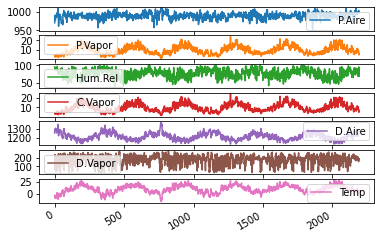

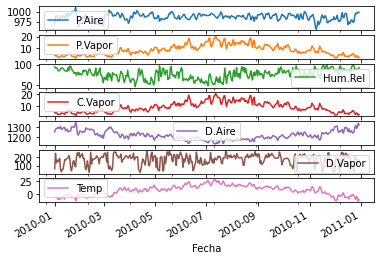

In [20]:
plot_cols = df2.columns
plot_feature = df2[plot_cols]
plot_feature_index = date_column
_ = plot_feature.plot(subplots=True)

plot_features = df2[plot_cols][:365]
plot_features.index = date_column[:365]
_ = plot_features.plot(subplots=True)


In [21]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
P.Aire,2193.0,989.291952,7.913174,951.56,984.38,989.46,994.39,1011.20
P.Vapor,2193.0,9.528664,4.106531,1.30,6.28,8.91,12.23,23.80
Hum.Rel,2193.0,75.839558,11.592708,38.50,67.52,76.75,84.44,100.00
C.Vapor,2193.0,9.635121,4.157923,1.29,6.34,8.98,12.36,24.12
D.Aire,2193.0,1216.120219,37.622388,1133.43,1188.26,1212.65,1242.08,1368.36
D.Vapor,2193.0,174.249950,54.484004,22.57,141.96,187.76,211.46,279.37
Temp,2193.0,9.462321,7.861140,-16.58,3.90,9.72,15.36,29.45


Divide los datos

Usaremos una división (70%, 20%, 10%) para los conjuntos de entrenamiento, validación y prueba. Tenga en cuenta que los datos no se mezclan aleatoriamente antes de dividirlos. Esto es por dos razones.

- Garantiza que aún sea posible dividir los datos en ventanas de muestras consecutivas.
- Garantiza que los resultados de la validación / prueba sean más realistas y se evalúen en función de los datos recopilados después de que el modelo fue entrenado.

In [22]:
column_indices = {name: i for i, name in enumerate(df2.columns)}
print(column_indices)

{'P.Aire': 0, 'P.Vapor': 1, 'Hum.Rel': 2, 'C.Vapor': 3, 'D.Aire': 4, 'D.Vapor': 5, 'Temp': 6}


In [23]:
n = len(df2)
train_df = df2[0:int(n*0.7)]
val_df = df2[int(n*0.7):int(n*0.9)]
test_df = df2[int(n*0.9):]

num_features = df2.shape[1]


Normalizar los datos

Es importante escalar características antes de entrenar una red neuronal. La normalización es una forma común de realizar esta escala. Reste la media y divida por la desviación estándar de cada característica.

La media y la desviación estándar solo deben calcularse utilizando los datos de entrenamiento para que los modelos no tengan acceso a los valores en los conjuntos de validación y prueba.

También se puede argumentar que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento durante el entrenamiento, y que esta normalización debería realizarse utilizando promedios móviles. Ese no es el enfoque de este tutorial, y los conjuntos de validación y prueba garantizan que obtenga métricas (algo) honestas. Entonces, en aras de la simplicidad, este tutorial utiliza un promedio simple.

In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

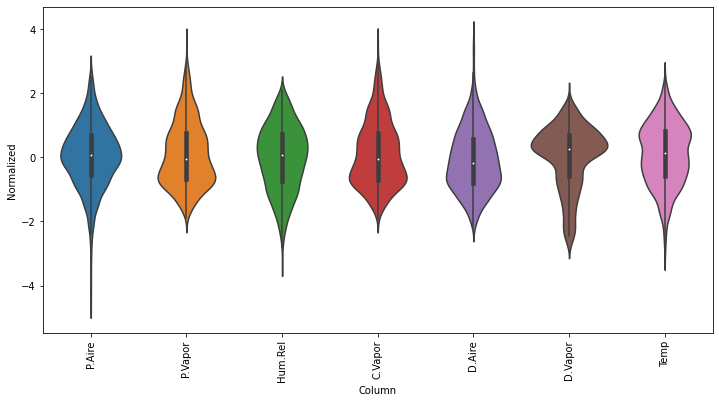

In [25]:
df_std = (df2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df2.keys(), rotation=90)


Tomado de https://www.tensorflow.org/tutorials/structured_data/time_series

In [26]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result
  
  def plot(self, model=None, plot_col='Temp', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

    plt.xlabel('Temp')

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [55]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=7,
    label_columns=['Temp']
)
single_step_window

Total window size: 8
Input indices: [0]
Label indices: [7]
Label column name(s): ['Temp']

In [56]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


Base

Antes de construir un modelo entrenable, sería bueno tener una línea de base de rendimiento como punto de comparación con los modelos posteriores más complicados.

In [57]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [58]:
baseline = Baseline(label_index=column_indices['Temp'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


14/14 [==============================] - 0s 1ms/step - loss: 0.3444 - mean_absolute_error: 0.4711


In [62]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=7,
    label_columns=['Temp'])

wide_window

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36]
Label column name(s): ['Temp']

In [63]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 30, 7)
Output shape: (32, 30, 1)


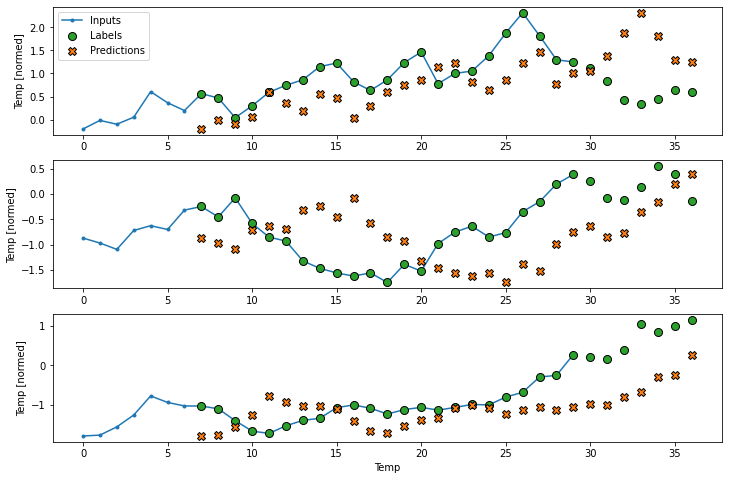

In [64]:
wide_window.plot(baseline)


In [65]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


In [66]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [67]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 30, 7)
Output shape: (32, 30, 1)


In [68]:
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
48/48 [==============================] - 0s 5ms/step - loss: 2.3162 - mean_absolute_error: 1.2487 - val_loss: 1.5407 - val_mean_absolute_error: 1.0290
Epoch 2/20
48/48 [==============================] - 0s 5ms/step - loss: 1.9153 - mean_absolute_error: 1.1256 - val_loss: 1.3028 - val_mean_absolute_error: 0.9439
Epoch 3/20
48/48 [==============================] - 0s 3ms/step - loss: 1.6053 - mean_absolute_error: 1.0226 - val_loss: 1.1248 - val_mean_absolute_error: 0.8738
Epoch 4/20
48/48 [==============================] - 0s 3ms/step - loss: 1.3719 - mean_absolute_error: 0.9408 - val_loss: 0.9926 - val_mean_absolute_error: 0.8175
Epoch 5/20
48/48 [==============================] - 0s 3ms/step - loss: 1.1988 - mean_absolute_error: 0.8763 - val_loss: 0.8943 - val_mean_absolute_error: 0.7736
Epoch 6/20
48/48 [==============================] - 0s 3ms/step - loss: 1.0687 - mean_absolute_error: 0.8238 - val_loss: 0.8198 - val_mean_absolute_error: 0.7377
Epoch 7/20
48/48 [==========

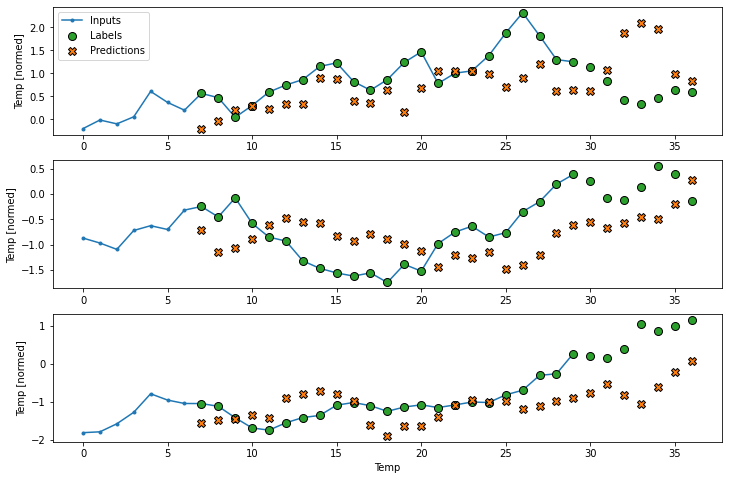

In [69]:
wide_window.plot(linear)

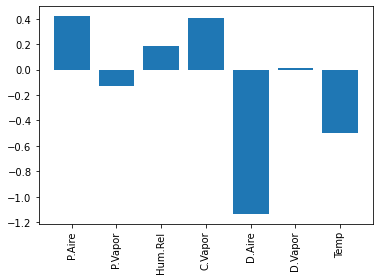

In [70]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


In [71]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
48/48 [==============================] - 0s 7ms/step - loss: 0.4362 - mean_absolute_error: 0.5231 - val_loss: 0.3067 - val_mean_absolute_error: 0.4399
Epoch 2/20
48/48 [==============================] - 0s 5ms/step - loss: 0.3422 - mean_absolute_error: 0.4644 - val_loss: 0.3042 - val_mean_absolute_error: 0.4384
Epoch 3/20
48/48 [==============================] - 0s 4ms/step - loss: 0.3291 - mean_absolute_error: 0.4577 - val_loss: 0.3033 - val_mean_absolute_error: 0.4382
Epoch 4/20
48/48 [==============================] - 0s 4ms/step - loss: 0.3233 - mean_absolute_error: 0.4514 - val_loss: 0.3032 - val_mean_absolute_error: 0.4369
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 0.3225 - mean_absolute_error: 0.4522 - val_loss: 0.3049 - val_mean_absolute_error: 0.4397
Epoch 6/20
14/14 [==============================] - 0s 2ms/step - loss: 0.3151 - mean_absolute_error: 0.4442


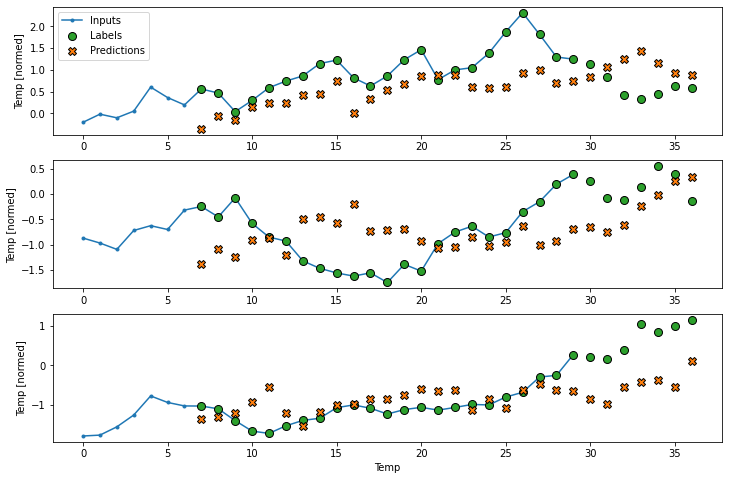

In [72]:
wide_window.plot(dense)

<h1>CNN

In [194]:
CONV_WIDTH = 180
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=7,
    label_columns=['Temp'])

conv_window

Total window size: 187
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
Label indices: [186]
Label column name(s): ['Temp']

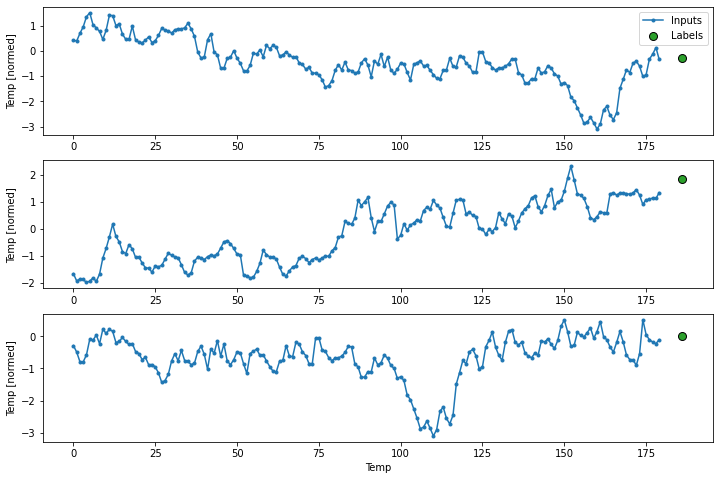

In [195]:
conv_window.plot()


In [196]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [197]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 180, 7)
Output shape: (32, 1, 1)


In [198]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)


8/8 [==============================] - 0s 2ms/step - loss: 0.3325 - mean_absolute_error: 0.4631


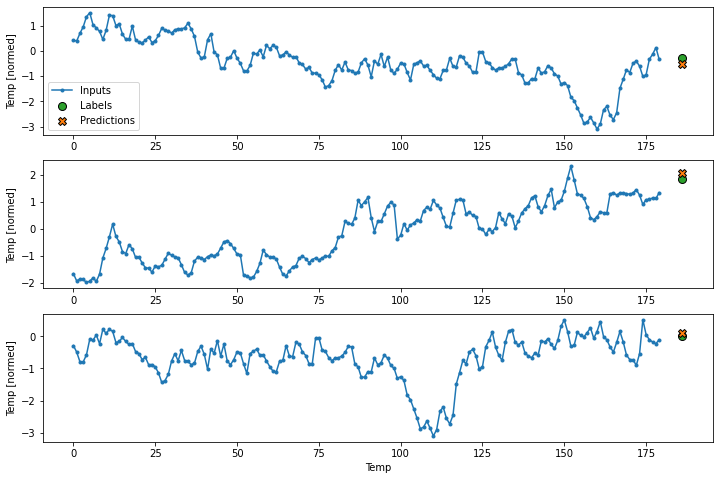

In [199]:
conv_window.plot(multi_step_dense)

In [200]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [201]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 180, 7)
Output shape: (32, 1, 1)


In [202]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


8/8 [==============================] - 0s 2ms/step - loss: 0.2818 - mean_absolute_error: 0.4340


In [203]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 30, 7)
Labels shape: (32, 30, 1)


InvalidArgumentError: Computed output size would be negative: -149 [input_size: 30, effective_filter_size: 180, stride: 1] [Op:Conv2D]

In [204]:
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=7,
    label_columns=['Temp'])

wide_conv_window

Total window size: 216
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208]
Label indices: [186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 

In [205]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 209, 7)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


In [206]:
history = compile_and_fit(conv_model, wide_conv_window)

IPython.display.clear_output()
val_performance['Conv Window'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv Window'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

7/7 [==============================] - 0s 2ms/step - loss: 0.2822 - mean_absolute_error: 0.4310


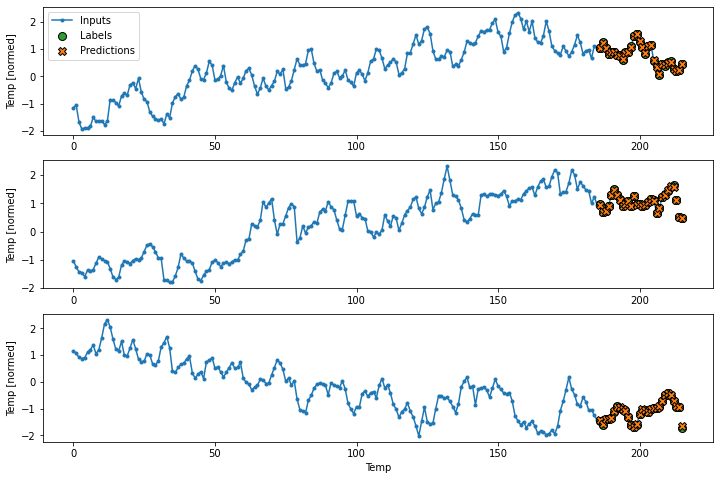

In [207]:
wide_conv_window.plot(conv_model)


In [208]:
performance

{'Baseline': [0.5492560863494873, 0.6037600636482239],
 'Linear': [0.5882707834243774, 0.6102898716926575],
 'Dense': [0.4680461585521698, 0.5484285950660706],
 'Multi step dense': [0.7873849868774414, 0.7999162077903748],
 'Conv': [0.4440206289291382, 0.5739615559577942],
 'Conv Window': [0.4197925925254822, 0.5763276815414429]}